## 1. Prepare and read the data

In [385]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from transformers import TFBertForSequenceClassification
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [386]:
# import data from xlsx file
complaints_file_name = 'banking_complaints_2023.xlsx'
complaints_sheet = 'complaints_banking_2023'
department_of_product_sheet = 'department_of_product'

df_complaints = pd.read_excel(complaints_file_name, sheet_name=complaints_sheet)
df_department_of_product = pd.read_excel(complaints_file_name, sheet_name=department_of_product_sheet)

In [387]:
df_complaints.head()

,complaint_id,date_received,banking_product,issue_id,complaint_description,state,zip,bank_response
0,CID76118977,2023-01-01,Checking or savings account,I_3510635,on XX/XX/XX22 I opened a safe balance account ...,California,92311,Closed with monetary relief
1,CID98703933,2023-01-01,"Credit reporting, credit repair services, or o...",I_3798538,There is an item from Bank of ABC on my credit...,California,91344,Closed with explanation
2,CID52036665,2023-01-01,Checking or savings account,I_3648593,On XX/XX/XX22 I found out that my account was ...,New York,10466,Closed with monetary relief
3,CID62581335,2023-01-01,Credit card or prepaid card,I_6999080,I've had a credit card for years with Bank of ...,California,92127,Closed with monetary relief
4,CID65731164,2023-01-01,Checking or savings account,I_3648593,This issue has to do with the way that Bank of...,New Jersey,7946,Closed with explanation


In [388]:
df_department_of_product

,banking_product,department
0,Checking or savings account,CASA
1,"Credit reporting, credit repair services, or o...",Credit Reports
2,Credit card or prepaid card,Credit Cards
3,Debt collection,Loans
4,"Money transfer, virtual currency, or money ser...",Remittance
5,Mortgage,Mortgage
6,Vehicle loan or lease,Loans
7,"Payday loan, title loan, or personal loan",Loans
8,Student loan,Loans
9,Other financial service,Others


## 2. Check the data and fix null values

In [389]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7011 entries, 0 to 7010
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   complaint_id           7011 non-null   object        
 1   date_received          7011 non-null   datetime64[ns]
 2   banking_product        7011 non-null   object        
 3   issue_id               7011 non-null   object        
 4   complaint_description  7011 non-null   object        
 5   state                  6984 non-null   object        
 6   zip                    6981 non-null   object        
 7   bank_response          7011 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 438.3+ KB


In [390]:
# Convert date_received to datetime
df_complaints['date_received'] = pd.to_datetime(df_complaints['date_received'])

In [391]:
# Check null values
df_complaints.isnull().sum()

complaint_id              0
date_received             0
banking_product           0
issue_id                  0
complaint_description     0
state                    27
zip                      30
bank_response             0
dtype: int64

In [392]:
# Pull department column from department_of_product_sheet into df_complaints based on the key banking_product
df_complaints = df_complaints.merge(df_department_of_product, on='banking_product', how='left')
df_complaints.head()

,complaint_id,date_received,banking_product,issue_id,complaint_description,state,zip,bank_response,department
0,CID76118977,2023-01-01,Checking or savings account,I_3510635,on XX/XX/XX22 I opened a safe balance account ...,California,92311,Closed with monetary relief,CASA
1,CID98703933,2023-01-01,"Credit reporting, credit repair services, or o...",I_3798538,There is an item from Bank of ABC on my credit...,California,91344,Closed with explanation,Credit Reports
2,CID52036665,2023-01-01,Checking or savings account,I_3648593,On XX/XX/XX22 I found out that my account was ...,New York,10466,Closed with monetary relief,CASA
3,CID62581335,2023-01-01,Credit card or prepaid card,I_6999080,I've had a credit card for years with Bank of ...,California,92127,Closed with monetary relief,Credit Cards
4,CID65731164,2023-01-01,Checking or savings account,I_3648593,This issue has to do with the way that Bank of...,New Jersey,7946,Closed with explanation,CASA


In [393]:
# Check null values
df_complaints.isnull().sum()

complaint_id                0
date_received               0
banking_product             0
issue_id                    0
complaint_description       0
state                      27
zip                        30
bank_response               0
department               1306
dtype: int64

In [394]:
# Display banking products without department assignment
df_complaints[df_complaints['department'].isnull()].groupby('banking_product').size().reset_index()

,banking_product,0
0,Bank account or service,256
1,Consumer Loan,83
2,Credit card,359
3,Credit reporting,550
4,Money transfers,11
5,Payday loan,30
6,Prepaid card,17


In [395]:
df_department_of_product

,banking_product,department
0,Checking or savings account,CASA
1,"Credit reporting, credit repair services, or o...",Credit Reports
2,Credit card or prepaid card,Credit Cards
3,Debt collection,Loans
4,"Money transfer, virtual currency, or money ser...",Remittance
5,Mortgage,Mortgage
6,Vehicle loan or lease,Loans
7,"Payday loan, title loan, or personal loan",Loans
8,Student loan,Loans
9,Other financial service,Others


In [396]:
for value in df_department_of_product['banking_product'].unique():
    print(value)

Checking or savings account
Credit reporting, credit repair services, or other personal consumer reports
Credit card or prepaid card
Debt collection
Money transfer, virtual currency, or money service
Mortgage
Vehicle loan or lease
Payday loan, title loan, or personal loan
Student loan
Other financial service


In [397]:
# Update null values department in df_complaints
df_complaints.loc[df_complaints['banking_product'] == 'Credit card', 'department'] = 'Credit Cards'
df_complaints.loc[df_complaints['banking_product'] == 'Prepaid card', 'department'] = 'Credit Cards'
df_complaints.loc[df_complaints['banking_product'] == 'Credit reporting', 'department'] = 'Credit Reports'
df_complaints.loc[df_complaints['banking_product'] == 'Money transfers', 'department'] = 'Remittance'
df_complaints.loc[df_complaints['banking_product'] == 'Bank account or service', 'department'] = 'CASA'
df_complaints.loc[df_complaints['banking_product'] == 'Consumer Loan', 'department'] = 'Loans'
df_complaints.loc[df_complaints['banking_product'] == 'Payday loan', 'department'] = 'Loans'

In [398]:
# Check null values in department again
df_complaints[df_complaints['department'].isnull()].groupby('banking_product').size().reset_index()

,banking_product,0


In [399]:
df_complaints.isnull().sum()

complaint_id              0
date_received             0
banking_product           0
issue_id                  0
complaint_description     0
state                    27
zip                      30
bank_response             0
department                0
dtype: int64

## Department column is now fully populated

In [400]:
df_complaints['department'].value_counts()

department
CASA              1911
Credit Cards      1609
Loans             1111
Credit Reports    1109
Mortgage           848
Remittance         422
Others               1
Name: count, dtype: int64

## State and Zip Code are not important for this analysis. There is no need to address null values in these columns.

## 3. Find date range

In [401]:
# Date range
date_range = df_complaints['date_received'].agg(['min', 'max'])
date_range

min   2023-01-01
max   2023-10-21
Name: date_received, dtype: datetime64[ns]

## Min date is 2023-01-01 and max date is 2023-10-21

## 4. Preprocessing function

In [402]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    text = text.lower() # convert to lowercase
    return text

In [403]:
# Function to remove numbers
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

In [ ]:
# Function to remove stopwords
stop_words = set(stopwords.words('english'))
sentiment_words = {'not', 'no', 'never', 'very', 'really', 'extremely'}
stop_words = stop_words - sentiment_words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

In [405]:
# Function to remove punctuation
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text) # 
    return text

In [406]:
# Function to remove extra spaces
def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text) # replace multiple spaces with a single space
    text = text.strip() # remove leading and trailing spaces
    return text

In [407]:
# Function to convert Penn Treebank tags to WordNet tags
def convert_pos_tag(penn_tag):
    if penn_tag.startswith('J'):
        return wordnet.ADJ
    elif penn_tag.startswith('V'):
        return wordnet.VERB
    elif penn_tag.startswith('N'):
        return wordnet.NOUN
    elif penn_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [408]:
# Function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_text = []
    for word, tag in pos_tags:
        wordnet_tag = convert_pos_tag(tag)
        if wordnet_tag:
            lemmatized_word = lemmatizer.lemmatize(word, pos=wordnet_tag)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_text.append(lemmatized_word)
    return lemmatized_text


In [409]:
# Define text preprocessing function
def preprocessing(text):
    text = convert_to_lowercase(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)
    lemmatized_tokens = lemmatize_text(text)
    return lemmatized_tokens

In [410]:
sample_text = df_complaints.loc[0, 'complaint_description']
print(sample_text)
print(preprocessing(sample_text))

on XX/XX/XX22 I opened a safe balance account online using my payroll check of over {$600.00} as my account opener. On XX/XX/XX22, I attempted to login to my app and received a " account locked contact customer service @ XXXX '' error message. I placed the call and was told I would have to go to a branch to verify my identity, which I did. At the same time, I was told I had a positive balance of of {$650.00} and could make a withdrawal from the teller, which I did for {$400.00} leaving a balance of + {$250.00}. Shortly after that, I deposited a mobile check for {$5XX.00}. On XX/XX/XX22, again I attempted to login and received the previous error message along with 3 emails stating a hold was placed on my account. Contacting the same previous number I was told that my acct was being closed by the Risk Dept. due to lack of identity verification, which I told them I had done the day before. I was then told it didn't matter the account was already being closed and it was not reversible, so 

## 5. Clean the text

In [411]:
df_complaints['lemmatized_tokens'] = df_complaints['complaint_description'].apply(preprocessing)

In [412]:
df_complaints['lemmatized_text'] = df_complaints['lemmatized_tokens'].apply(lambda x: ' '.join(x))

In [413]:
df_complaints[['complaint_description', 'lemmatized_tokens', 'lemmatized_text']].head(10)

,complaint_description,lemmatized_tokens,lemmatized_text
0,on XX/XX/XX22 I opened a safe balance account ...,"[xxxxxx, open, safe, balance, account, online,...",xxxxxx open safe balance account online use pa...
1,There is an item from Bank of ABC on my credit...,"[item, bank, abc, credit, report, belong, must...",item bank abc credit report belong must remove...
2,On XX/XX/XX22 I found out that my account was ...,"[xxxxxx, find, account, frozen, apparent, reas...",xxxxxx find account frozen apparent reason go ...
3,I've had a credit card for years with Bank of ...,"[credit, card, year, bank, abc, xxxxxxxx, pay,...",credit card year bank abc xxxxxxxx pay balance...
4,This issue has to do with the way that Bank of...,"[issue, way, bank, abc, account, link, bill, p...",issue way bank abc account link bill pay part ...
5,"So, last time I was on the phone with b of a p...","[so, last, time, phone, b, prepaid, regard, ed...",so last time phone b prepaid regard edd accoun...
6,"Got 5 hard inquiries I dont recognize, from XX...","[get, hard, inquiry, dont, recognize, xxxx, xx...",get hard inquiry dont recognize xxxx xxxx xxxx...
7,"In XXXX of XX22, I discovered that a former te...","[xxxx, xx, discover, former, tenant, steal, id...",xxxx xx discover former tenant steal identity ...
8,"I, the consumer am aware and have proof that B...","[i, consumer, aware, proof, bank, abc, continu...",i consumer aware proof bank abc continue viola...
9,I have filed a dispute in regards to an inaccu...,"[file, dispute, regard, inaccurate, account, c...",file dispute regard inaccurate account consume...


## 6. Convert preprocessed text into TF-IDF features 

In [414]:
# Convert preprocessed text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word') # Initialize TF-IDF Vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(df_complaints['lemmatized_text']) # Fit and transform the lemmatized text
tfidf_columns = tfidf_vectorizer.get_feature_names_out() # Get feature names
tfidf_array = tfidf_matrix.toarray() # Convert sparse matrix to dense array
tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf_columns) # Create DataFrame
tfidf_df.head()

,abc,abcn,ability,able,absolutely,abuse,accept,access,accord,accordance,...,xxxxxx,xxxxxxxx,xxxxxxxxxx,xxxxxxxxxxxx,year,yes,yesterday,yet,you,zero
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.171555,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.077645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.124374,0.094499,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.024046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.120800,0.0,0.0,0.036322,0.0,0.0,0.0,0.0,0.0
4,0.233271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 7.1 Build Random Forest classification model to predict the department

In [415]:
# Prepare the data
X = tfidf_df
y = df_complaints['department']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the classification model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize Random Forest Classifier

# Train the model
rf_model.fit(X_train, y_train)

# Predict the outcome
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Calculate the probabilities
y_pred_train_proba_rf = rf_model.predict_proba(X_train)
y_pred_test_proba_rf = rf_model.predict_proba(X_test)

In [416]:
# Determine the class order
class_order = rf_model.classes_
print("Class order:", class_order)

# Create a DataFrame to display actual and predicted labels with probabilities
results_df = pd.DataFrame({
    'Actual Label': y_test,
    'Predicted Label': y_pred_test_rf,
})

# Add predicted probabilities with correct class names
for i, class_name in enumerate(class_order):
    results_df[f'Proba {class_name}'] = np.round(y_pred_test_proba_rf[:, i], 2)

# Display the first few rows of the results DataFrame
results_df.head()

Class order: ['CASA' 'Credit Cards' 'Credit Reports' 'Loans' 'Mortgage' 'Others'
 'Remittance']


,Actual Label,Predicted Label,Proba CASA,Proba Credit Cards,Proba Credit Reports,Proba Loans,Proba Mortgage,Proba Others,Proba Remittance
6851,CASA,Credit Cards,0.24,0.44,0.14,0.07,0.08,0.0,0.03
6724,CASA,CASA,0.61,0.19,0.02,0.02,0.05,0.0,0.11
245,Credit Reports,Credit Reports,0.16,0.19,0.51,0.06,0.04,0.0,0.04
1880,Credit Cards,CASA,0.49,0.06,0.05,0.01,0.03,0.0,0.36
6799,Loans,Credit Reports,0.05,0.02,0.72,0.21,0.00,0.0,0.00


In [417]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train_rf)
test_accuracy = accuracy_score(y_test, y_pred_test_rf)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9998
Test Accuracy: 0.7277


## Random Forest results
### Train Accuracy: 0.9998
### Test Accuracy: 0.7277


## 7.2 Build a Deep Neural Network classification model to predict the department

In [418]:
# Prepare the data
y_categorical = pd.get_dummies(y, prefix='department').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [419]:
# Create the DNN model
input_shape = (X_train.shape[1],)
output_shape = y_train.shape[1]
print(f"Input shape: {input_shape}, Output shape: {output_shape}")

Input shape: (1000,), Output shape: 7


In [420]:
dnn_model = Sequential([
    Input(shape=input_shape),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(output_shape, activation='softmax')
])

In [421]:
dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 32)             │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,951 (128.71 KB)

 Trainable params: 32,951 (128.71 KB)

 Non-trainable params: 0 (0.00 B)

In [422]:
# Epoch logger callback
class EpochLogger(Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            log_str = f"Epoch {epoch + 1}: " + ", ".join(
                [f"{k}: {v:.4f}" for k, v in logs.items()]
            )
            print(log_str)

In [423]:
# Define early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [424]:
# Train the model
history = dnn_model.fit(
    X_train, y_train,
    epochs=500,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        EpochLogger(interval=10),
        early_stopping
    ]
)

Epoch 10: accuracy: 0.8827, loss: 0.3616, val_accuracy: 0.7398, val_loss: 0.8020
Epoch 20: accuracy: 0.9617, loss: 0.1297, val_accuracy: 0.7050, val_loss: 1.1974
Epoch 30: accuracy: 0.9840, loss: 0.0579, val_accuracy: 0.7112, val_loss: 1.6217
Epoch 40: accuracy: 0.9915, loss: 0.0319, val_accuracy: 0.7050, val_loss: 1.9778
Epoch 50: accuracy: 0.9918, loss: 0.0254, val_accuracy: 0.7094, val_loss: 2.2600


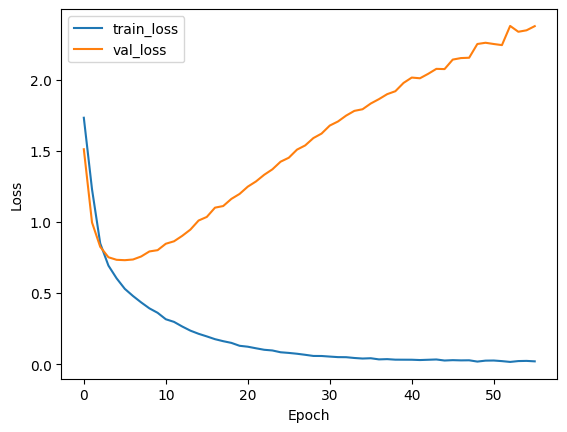

In [425]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Deep neural networks overfit. Random Forest is more robust.

## 8. Sentiment Analysis

In [426]:
analyzer = SentimentIntensityAnalyzer()
df_complaints['sentiment_scores_neg'] = df_complaints['complaint_description'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_complaints['sentiment_scores_pos'] = df_complaints['complaint_description'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df_complaints['sentiment_scores_neu'] = df_complaints['complaint_description'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
df_complaints['sentiment_scores_compound'] = df_complaints['complaint_description'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

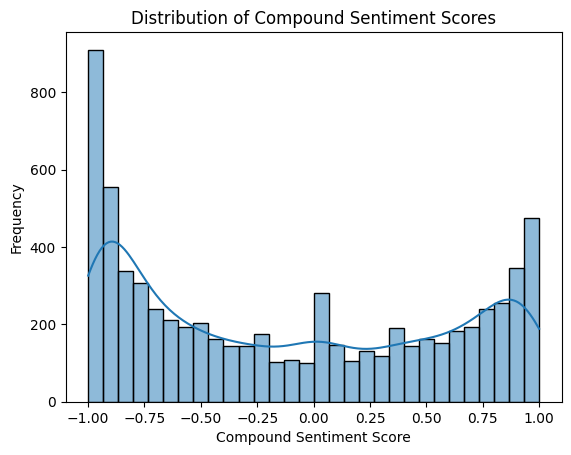

In [427]:
# Plot compound sentiment scores
#plt.figure(figsize=(10, 6))
sns.histplot(df_complaints['sentiment_scores_compound'], bins=30, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [439]:
print(df_complaints[df_complaints['sentiment_scores_compound'] > 0.8]['complaint_description'][43])

I have a business account in BOA. I am the owner of the company. I usually use my mobile phone to deposit customers ' checks. 

On XX/XX/XX22, I used my mobile phone to deposit a check for {$40000.00}. The next day, I couldn't log in to the online bank. I casually called BOA and said that my account had been closed. The funds in it were being reviewed by the relevant departments of BOA. After the review, the balance, about {$4XX00.00}, would be sent to me by check. 

For nearly four months now, boa still hasn't sent me the check. Every time I calls, he just says that they are reviewing, and can't reply when the review ends or any other questions. 

I want to get my money back as soon as possible, or they can return the last {$40000.00} to the customer who paid me. 

Please help me, thank you


## Despite the data being about complaints, the sentiment analysis reveals that there are positive sentiment scores in the complaints. This could indicate that customers are expressing their grievances in a constructive manner, or it could be due to the nature of the complaints being related to issues that have been resolved or are in the process of being resolved.

## However, as expected, the negative sentiments are in majority.

## The bank can use the sentiment score to achieve the following:
### 1. Prioritize customer complaints based on sentiment scores
### 2. Prevent escalation of negative sentiments
### 3. Prevent customer churn and improve customer satisfaction by addressing negative sentiments promptly and in a customized manner
### 4. Monitor changes in customer sentiment over time to assess the changes in the quality of customer service
### 5. Use as a KPI to measure the effectiveness of customer service initiatives